In [10]:
from torch.nn import CrossEntropyLoss

from datasets.ClusteredStormDamageDataset import ClusteredStormDamageDataset
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from datasets.NormalizedClusteredStormDamageDataset import NormalizedClusteredStormDamageDataset
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE


In [11]:
train_dataset = NormalizedClusteredStormDamageDataset('../../Ressources/main_data_1972_2023.csv',
                                    '../../Ressources/weather_data4',
                                    '../../Ressources/municipalities_coordinates_newest.csv',
                                              n_clusters=6,
                                              n_sequences=0, test_years=10,
                                              grouping_calendar='weekly', split='train',
                                              damage_weights={0: 0, 1: 0.06, 2: 0.8, 3: 11.3})
mean, std = train_dataset.mean, train_dataset.std

test_dataset = NormalizedClusteredStormDamageDataset('../../Ressources/main_data_1972_2023.csv',
                                    '../../Ressources/weather_data4',
                                    '../../Ressources/municipalities_coordinates_newest.csv',
                                              n_clusters=6,
                                              n_sequences=0, test_years=10,
                                              grouping_calendar='weekly', split='test',
                                              damage_weights={0: 0, 1: 0.06, 2: 0.8, 3: 11.3},
                                                mean=mean, std=std)

low threshold: 4.000000000000002
mid thresh: 15.702195524999984
low threshold: 4.000000000000002
mid thresh: 15.702195524999984


In [12]:
mean, std

(tensor([8.7132e+00, 2.8966e+04, 2.4517e+01, 3.6764e+00, 6.5267e+00, 2.1847e-01,
         4.6815e+01, 8.0905e+00]),
 tensor([7.3103e+00, 1.0314e+04, 2.8042e+01, 8.0447e+00, 3.4481e+00, 4.1321e-01,
         4.1761e-01, 9.1194e-01]))

In [13]:
all_X_train, all_y_train = [], []
for feat, lbl in train_dataset:
    cur = feat[0].numpy()
    all_X_train.append(cur)
    all_y_train.append(1 if lbl > 0 else 0)
all_X_train = np.vstack(all_X_train)
all_y_train = np.array(all_y_train)

/Users/nilsgamperli/PycharmProjects/StormMind/ai_engineering/datasets/NormalizedClusteredStormDamageDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(self.mean, device=features.device)
/Users/nilsgamperli/PycharmProjects/StormMind/ai_engineering/datasets/NormalizedClusteredStormDamageDataset.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(self.std,  device=features.device)


In [14]:
all_X_test, all_y_test = [], []
for feat, lbl in test_dataset:
    cur = feat[0].numpy()
    all_X_test.append(cur)
    all_y_test.append(1 if lbl > 0 else 0)
all_X_test = np.vstack(all_X_test)
all_y_test = np.array(all_y_test)

In [15]:
all_X_train.shape, all_y_train.shape, all_X_train.shape, all_y_test.shape

((13146, 8), (13146,), (13146, 8), (3132,))

In [12]:
compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=all_y_train)

array([0.63977029, 2.28864903])

In [16]:
all_X_train[:, 4] = all_X_train[:, 4] * std[4].numpy() + mean[4].numpy()
all_X_test[:, 4] = all_X_test[:, 4] * std[4].numpy() + mean[4].numpy()

In [17]:
np.unique(all_X_train[:,4])

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
      dtype=float32)

In [18]:
# put months into seasons:
def month_to_season(months):
    # months is a NumPy array of shape (N,)
    return np.select(
        [np.isin(months, [12, 1, 2]),
         np.isin(months, [3, 4, 5]),
         np.isin(months, [6, 7, 8]),
         np.isin(months, [9, 10, 11])],
        [0, 1, 2, 3]
    )

def month_to_sine(months):
    return np.sin((2*np.pi*months)/12)

In [19]:
all_X_train[:, 4] = month_to_sine(all_X_train[:, 4].astype(int))
all_X_test[:, 4] = month_to_sine(all_X_test[:, 4].astype(int))

In [20]:
np.unique(all_X_train[:,4]), np.unique(all_X_test[:,4])

(array([-1.0000000e+00, -8.6602539e-01, -5.0000000e-01, -2.4492937e-16,
         1.2246469e-16,  5.0000000e-01,  8.6602539e-01,  1.0000000e+00],
       dtype=float32),
 array([-1.0000000e+00, -8.6602539e-01, -5.0000000e-01, -2.4492937e-16,
         1.2246469e-16,  5.0000000e-01,  8.6602539e-01,  1.0000000e+00],
       dtype=float32))

Row features:
t2m, sun, rain, snow, date_tensor, label_old, lat_tensor, long_tensor

In [21]:
#X_train = np.concatenate((all_X_train[:, :3], all_X_train[:, 4:8]), axis=1)
#X_test = np.concatenate((all_X_test[:, :3], all_X_test[:, 4:8]), axis=1)
X_train = all_X_train[:,:3]
X_test = all_X_test[:,:3]

array([[-1.5121783 ,  0.8958607 ],
       [-0.8187152 , -0.4371171 ],
       [-0.6945759 , -0.8197718 ],
       [-0.45970234, -1.5437608 ],
       [ 0.57930934,  1.4305598 ],
       [ 0.5843975 ,  1.4228282 ],
       [ 0.897354  , -0.681327  ],
       [ 0.9043213 , -0.66375816],
       [ 0.9136381 , -0.64026505],
       [ 0.9334857 , -0.5902174 ],
       [ 1.0105203 , -0.3959666 ],
       [ 1.0247493 , -0.36008686],
       [ 1.060204  , -0.27068424],
       [ 1.1017642 , -0.16588612],
       [ 1.1493247 , -0.04595742],
       [ 1.2465516 ,  0.19921002],
       [ 1.2908598 ,  0.31093773],
       [ 1.3003677 ,  0.33491284]], dtype=float32)

In [66]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, all_y_train)

In [22]:
X_train.shape, all_y_train.shape

((13146, 3), (13146,))

In [23]:
np.unique(all_y_train), np.unique(all_y_test)

(array([0, 1]), array([0, 1]))

In [24]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3,16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )

    def forward(self, x):
        return self.net(x)

In [73]:
coords = X_train[:, 5:7]
unique_coords, coord_indices = np.unique(coords, axis=0, return_inverse=True)
unique_coords

array([[-1.5121783 ,  0.8958607 ],
       [-0.8187152 , -0.4371171 ],
       [-0.45970234, -1.5437608 ],
       [ 0.57930934,  1.4305598 ],
       [ 0.897354  , -0.681327  ],
       [ 1.3003677 ,  0.33491284]], dtype=float32)

In [25]:
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(all_y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(all_y_test, dtype=torch.long)

# Dataset and DataLoader
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32)


In [31]:
def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
       for input, labels in dataloader:
            outputs= model(input)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            threshold = 0.45 # Example: more conservative, favors precision
            predictions = (predictions >= threshold).long()

            all_preds.append(predictions)
            all_labels.append(labels)

    all_labels = np.concatenate(all_labels)
    all_pred = np.concatenate(all_preds)
    report =  classification_report(all_labels, all_pred, zero_division=0.0, output_dict=True)
    cm = confusion_matrix(all_labels, all_pred)
    accuracy = report["accuracy"]
    f1 = report["macro avg"]["f1-score"]
    return running_loss / len(dataloader), report, accuracy, cm, f1

In [32]:
from sklearn.utils import compute_class_weight


model = SimpleMLP()
# Class weights

weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=all_y_train)
weights = torch.tensor(weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=0.1, end_factor=1, total_iters=100)
print(weights)

# Training loop
train_losses = []
val_losses = []
accs = []
f1s = []
for epoch in range(60):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    val_loss, _, acc, _, f1 = validate(model, test_loader, criterion)
    val_losses.append(val_loss)
    accs.append(acc)
    f1s.append(f1)
    scheduler.step()

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {val_loss:.4f} | Accuracy = {acc:.4f}")


tensor([0.6398, 2.2886])
Epoch 1: Train Loss = 0.6975 | Val Loss = 0.6916 | Accuracy = 0.2905
Epoch 2: Train Loss = 0.6973 | Val Loss = 0.6916 | Accuracy = 0.2905
Epoch 3: Train Loss = 0.6971 | Val Loss = 0.6917 | Accuracy = 0.2905
Epoch 4: Train Loss = 0.6969 | Val Loss = 0.6917 | Accuracy = 0.2905
Epoch 5: Train Loss = 0.6967 | Val Loss = 0.6918 | Accuracy = 0.2905
Epoch 6: Train Loss = 0.6964 | Val Loss = 0.6918 | Accuracy = 0.2905
Epoch 7: Train Loss = 0.6962 | Val Loss = 0.6919 | Accuracy = 0.2905
Epoch 8: Train Loss = 0.6959 | Val Loss = 0.6920 | Accuracy = 0.2905
Epoch 9: Train Loss = 0.6956 | Val Loss = 0.6920 | Accuracy = 0.2905
Epoch 10: Train Loss = 0.6953 | Val Loss = 0.6921 | Accuracy = 0.2905
Epoch 11: Train Loss = 0.6950 | Val Loss = 0.6922 | Accuracy = 0.2905
Epoch 12: Train Loss = 0.6947 | Val Loss = 0.6923 | Accuracy = 0.2905
Epoch 13: Train Loss = 0.6944 | Val Loss = 0.6924 | Accuracy = 0.2905
Epoch 14: Train Loss = 0.6940 | Val Loss = 0.6925 | Accuracy = 0.2905
Epoc

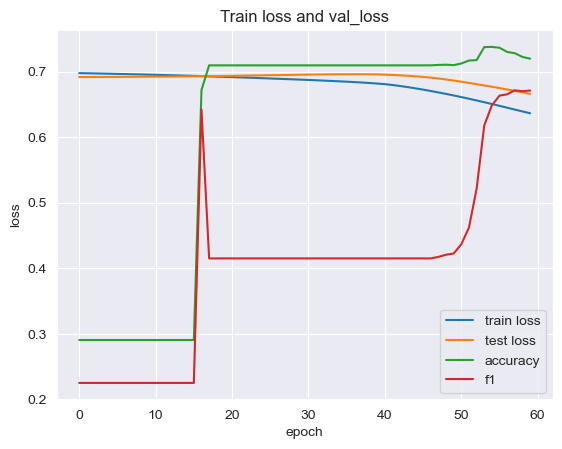

In [33]:
epochs = [i for i in range(60)]
plt.plot(epochs, train_losses, label='train loss')
plt.plot(epochs, val_losses, label='test loss')
plt.plot(epochs, accs, label='accuracy')
plt.plot(epochs, f1s, label= 'f1')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Train loss and val_loss")
plt.show()

In [34]:
print(f1s[-1])

0.6710575171104408


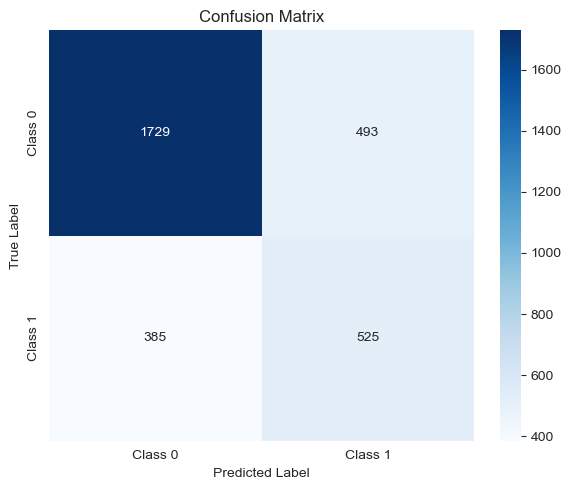

In [35]:
_, _, _, cm, _ = validate(model, test_loader, criterion)
import seaborn as sns

# Optional: define class names
class_names = ["Class 0", "Class 1"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()




              precision    recall  f1-score   support

           0       0.84      0.65      0.73      2222
           1       0.45      0.69      0.55       910

    accuracy                           0.66      3132
   macro avg       0.64      0.67      0.64      3132
weighted avg       0.73      0.66      0.68      3132

simple model with (temp, sun, rain, snow). Therefor snow did not use anything

              precision    recall  f1-score   support

           0       0.83      0.71      0.77      2222
           1       0.48      0.65      0.55       910

    accuracy                           0.69      3132
   macro avg       0.66      0.68      0.66      3132
weighted avg       0.73      0.69      0.70      3132


In [ ]:
torch.save(model.state_dict(), "../trained_models/small_nn_acc73_f1")